In [3]:
!pip install -qU langchain-google-genai gradio tensorflow keras pillow
import os
from google.colab import userdata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
from langchain_google_genai import ChatGoogleGenerativeAI
import gradio as gr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


try:
    df = pd.read_csv('dataset.csv')
except FileNotFoundError:
    print("Error: dataset.csv not found. Please upload the dataset file.")
    exit()


features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
target = 'target'
X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy}")

def predict_heart_disease(name, age, trestbps, chol, thalach, oldpeak):
    input_data = pd.DataFrame([[age, trestbps, chol, thalach, oldpeak]], columns=features)
    prediction = rf_model.predict(input_data)[0]
    if prediction == 1:
        return f"{name}, You may have heart disease. Please consult a doctor and consider uploading an X-ray."
    else:
        return f"{name}, You seem fine. But maintain healthy habits."

def health_chatbot(user_input):
    """
    Healthcare chatbot function using Google Gemini.

    Args:
        user_input: The user's medical query.

    Returns:
        The chatbot's response.
    """
    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")  # Ensure API key is set
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2
    )

    health_keywords = ["symptom", "disease", "illness", "treatment", "diagnosis", "medication", "health", "doctor", "hospital", "medical"]
    if any(keyword in user_input.lower() for keyword in health_keywords):
      message = [
          ("system", "You are a helpful and harmless medical assistant. Always answer in a friendly and informative way. Prioritize patient safety and well-being above all else. If you are unsure of an answer, recommend consulting a medical professional.  Do not provide medical diagnoses or treatment plans. Your responses should be for informational purposes only."),
          ("human", user_input),
      ]
      ai_msg = llm.invoke(message)
      return ai_msg.content
    else:
      return "This chatbot is designed for health-related queries. Please ask a question about a medical topic."

def generate_synthetic_xray_data(num_samples=100, img_size=(64, 64)):
    x_data = np.random.rand(num_samples, img_size[0], img_size[1], 3)  # Random images
    y_data = np.random.randint(0, 2, num_samples)  # Random binary labels (0 or 1)
    return x_data, y_data

x_synthetic, y_synthetic = generate_synthetic_xray_data()

def create_cnn_model():
    cnn_model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model


cnn_model = create_cnn_model()
cnn_model.fit(x_synthetic, y_synthetic, epochs=5, batch_size=10)


def predict_heart_disease_image(image):
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img = img.resize((64, 64))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = cnn_model.predict(img_array)[0][0]
    if prediction > 0.5:
        return "Heart disease detected."
    else:
        return "No heart disease detected."

with gr.Blocks() as demo:
    gr.Markdown("## Heart Disease Prediction")
    with gr.Row():
        with gr.Column():
            name = gr.Textbox(label="Name")
            age = gr.Number(label="Age")
            trestbps = gr.Number(label="Resting Blood Pressure (trestbps)")
            chol = gr.Number(label="Cholesterol (chol)")
            thalach = gr.Number(label="Maximum Heart Rate (thalach)")
            oldpeak = gr.Number(label="ST Depression (oldpeak)")
            predict_btn = gr.Button("Predict")
            output = gr.Textbox(label="Prediction")
            predict_btn.click(predict_heart_disease, inputs=[name, age, trestbps, chol, thalach, oldpeak], outputs=output)
        with gr.Column():
            gr.Markdown("## Health Chatbot")
            chatbot_input = gr.Textbox(label="Enter your health query")
            chatbot_output = gr.Textbox(label="Chatbot Response")
            chatbot_button = gr.Button("Ask")
            chatbot_button.click(health_chatbot, inputs=chatbot_input, outputs=chatbot_output)

            gr.Markdown("## Heart Disease Prediction from Chest X-Ray")
            image_input = gr.Image(label="Upload X-ray image", type="numpy")
            output = gr.Textbox(label="Prediction")
            submit_btn = gr.Button("Predict")
            submit_btn.click(predict_heart_disease_image, inputs=image_input, outputs=output)
demo.launch(share=True)

Random Forest Model Accuracy: 0.7213114754098361
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3623 - loss: 1.1517
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3978 - loss: 0.6970
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5638 - loss: 0.6911
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5408 - loss: 0.6886
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4859 - loss: 0.6899
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16b5e032d129b94ac6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Analysing Data Set


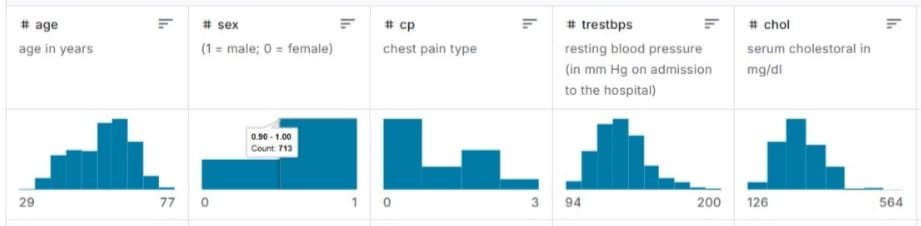

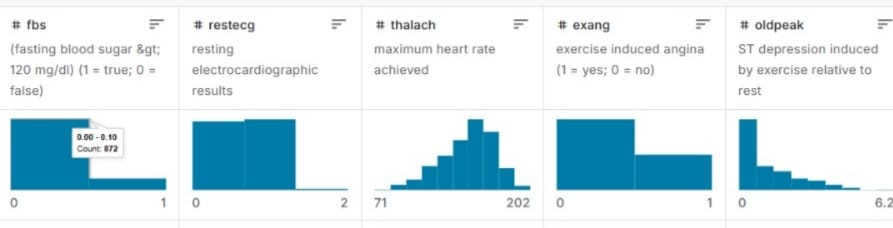

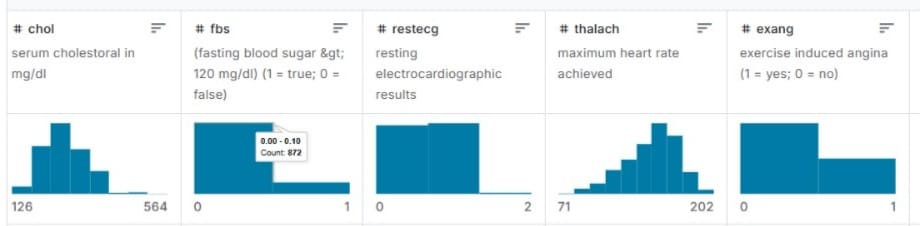

### Performing EDA and Histogram

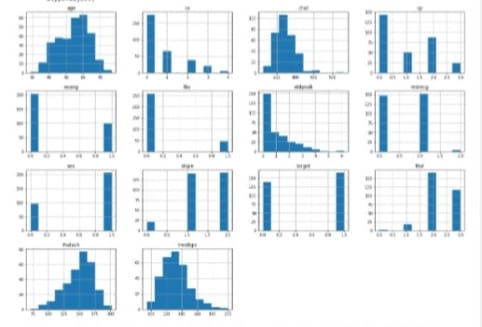

### The given Data is Balanced

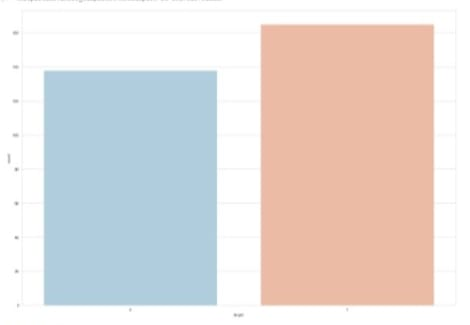

### Finding important Features

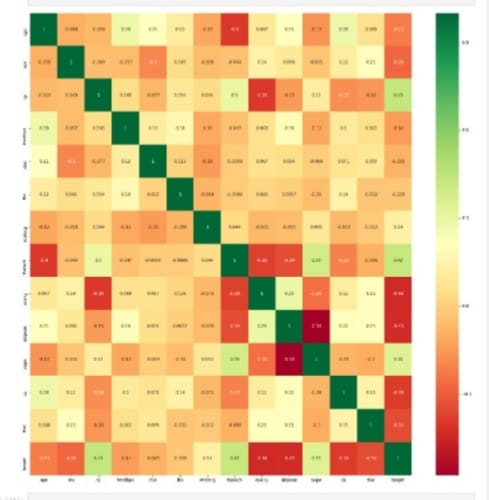

## CNN

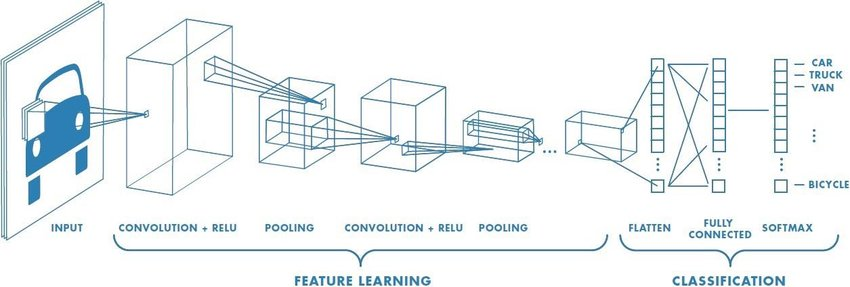